In [38]:
# Let's start by importing the libraries we will need below.

from google.colab import drive
drive.mount('/content/drive')

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/April')  # Here is the location of my stock historical database.
from pipelines import loaders, filters, interpolators  # Import my own data pipelines.

print("Imported Libraries")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Imported Libraries


In [50]:
# Let's choose from a number of stocks to get a good feel for our EDA.
# For argument's sake let's select two of the highest and two of the lowest performing stocks in 2021.
# However, depending on your strategy you might weight trades more to positive momentum, market cap, or trade volume.

tickers = ['AAPL', 'AMD', 'WYNN', 'ETSY']
yf_filepath = '/content/drive/MyDrive/Colab Notebooks/April/data/yf'
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']  # We will request OHLCV data from our database.
historicals = loaders.load_historicals(tickers, columns, yf_filepath)  # Loaded as a dict, with each key being a ticker string and with values as a pandas dataframe.
display(historicals['AAPL'].head())  # Let's see an example of our loaded historicals.

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-22,2.729483,2.730096,2.622619,2.657526,1.454026e+09
2007-01-23,2.625068,2.679571,2.618331,2.624149,1.207424e+09
2007-01-24,2.654158,2.668550,2.635786,2.654771,9.278136e+08
2007-01-25,2.667324,2.709886,2.634254,2.640991,9.059736e+08
2007-01-26,2.667324,2.675285,2.602409,2.614351,9.868740e+08


###1. Basic Returns


In [51]:
# Starting with the basic returns transformation as stated earlier in the readme.md file of the repository.

def transform_by_daily_returns(historicals):
  '''Transforms historical OHLCV data to their daily returns.

  Daily percent returns are calculated with the equation (P2/P1)-1.
  Where P2 is the OHLCV data for the current day and P1 is the OHLCV data.
  A (-1) is added to the equation to help center the mean around 0 
  for analysis later. See "_calculate_daily_returns(ohlcv)" for calculation 
  details.
  
  Args:
    historicals: dict with tickers as keys and values
                 as pandas dataframes.

  Returns:
    historicals_by_returns: dict with tickers as keys and values
                            as pandas dataframes with calculated
                            daily returns.
  '''

  historicals_by_returns = {}
  for ticker, ohlcv in historicals.items():
    historicals_by_returns[ticker] = _calculate_daily_returns(ohlcv)
  return historicals_by_returns

def _calculate_daily_returns(ohlcv):
  '''Calculates daily returns for the given stock history.'''
  daily_returns = ((ohlcv.shift(-1) / ohlcv) - 1)  # Add a (-1) to center the mean around 0.
  shifted_index = daily_returns.index[1:]  # Shift index forward so returns line up with their current date.
  daily_returns = daily_returns.dropna()
  daily_returns.index = shifted_index
  return daily_returns

historicals_by_returns = transform_by_daily_returns(historicals)
display(historicals_by_returns['AMD'].head())  # Let's take a quick look at the daily returns below.

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-23,0.000569,0.003401,0.006373,-0.001141,0.034550
2007-01-24,-0.077273,-0.070621,-0.082902,-0.084523,1.945157
2007-01-25,-0.006158,-0.002432,0.004394,0.001248,-0.585950
2007-01-26,0.000620,-0.008531,0.000625,0.010592,-0.072891
2007-01-29,0.003715,-0.002459,-0.009994,-0.016646,0.048535


count    1703.000000
mean        0.001697
std         0.037610
min        -0.283411
25%        -0.016266
50%         0.000594
75%         0.019510
max         0.306001
Name: Close, dtype: float64

Skewness is 0.54749995470047
Kurtosis is 9.946845054626465



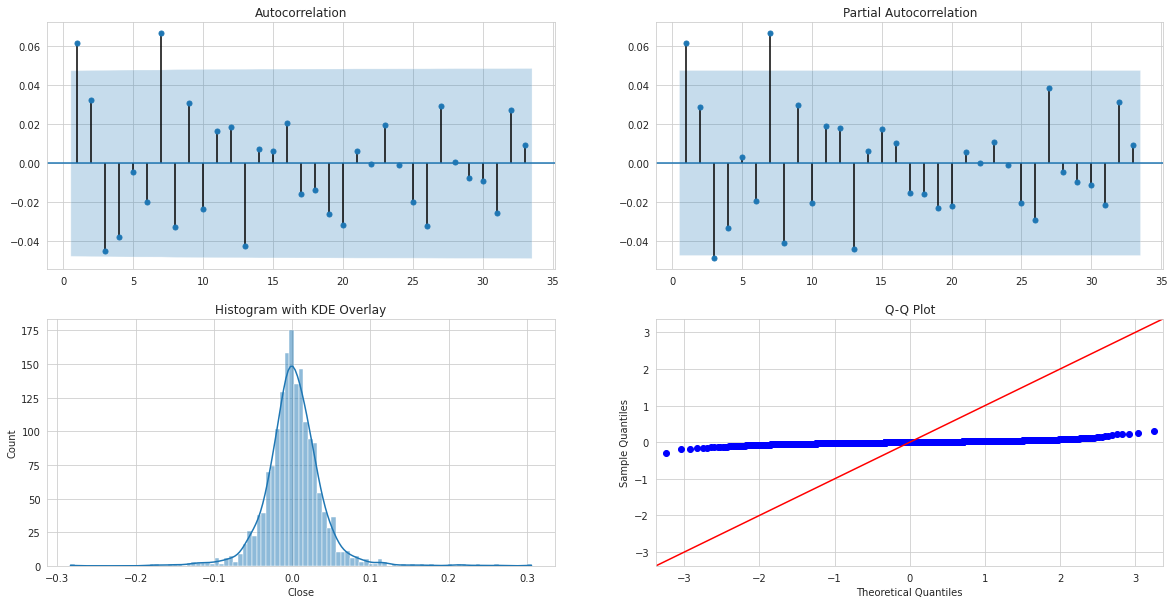

In [60]:
# Let's calculate the statistical properties of the basic returns data and some
# some typical statistical graphs. In this 

def plot_stationary_graphs(price_history):
  '''Prints the data's statistical properties and a collection of stationary graphs.

  Included graphs are as follows:
  1. ACF Plot
    - Autocorrelation Function Plot describes relations between a value
      and its past values. Checks for stationarity and a constant mean / variance.
  2. PACF Plot
    - Partial Autocorrelation Function Plot is similar to an ACF Plot but 
      removes correlations between the shorter lags. Checks for stationarity 
      and a constant mean / variance.
  3. Histogram Plot with Kernel Density Estimation
    - For visualization of the distribution of the data.
  4. Q-Q Plot
    - Quantile-Quantile Plot comparing our data's distribution on
      the sample quantiles axis against a normal distribution on
      the theoretical quantiles. If the data lines up on the center 
      y=x line, the data follows a normal distribution.

  Args:
    price_history: pandas series or array of a single price history column.

  Returns:
    None
  '''

  print(price_history.describe())
  print('\nSkewness is {}'.format(price_history.skew()))
  print('Kurtosis is {}\n'.format(price_history.kurtosis()))

  %matplotlib inline
  figure_dims = (20, 10)
  fig, ax = plt.subplots(2,2, figsize=figure_dims)
  sns.set_style('whitegrid')

  ax[0][0] = plot_acf(price_history, zero=False, ax=ax[0][0])
  ax[0][1] = plot_pacf(price_history, zero=False, ax=ax[0][1])

  ax[1][0] = sns.histplot(data=price_history, kde=True, ax=ax[1][0])
  ax[1][0].title.set_text('Histogram with KDE Overlay')

  sm.qqplot(price_history, line='45', ax=ax[1][1])
  ax[1][1].title.set_text('Q-Q Plot')
  plt.show()

plot_stationary_graphs(historicals_by_returns['ETSY']['Close'])  # Run and examine the visualizations.
                                                                 # You can run the other tickers or OHLC data for yourself (they all look similar).

In [ ]:
# A normal distribution can be described with the following statistical properties:
# Mean = 0, standard deviation = 1, skew = 0, and a kurtosis = 3.
# There are two statsitical properties that differ greatly from a normal distribution.
# This is the low standard deviation and high kurtosis compared to the gaussian normal.
# The term black swan events in trading can be seen here with high kurtosis causing both the
# Q-Q plot and the normal distribution to have long (fat) tails at the end. Additionally, the
# low standard deviation causes the majority of data points to be spread around the mean.
# The majority of trading strategies profit off the events that happen often with the clumping
# of the data points around the center, but otherwise will get blown out by a black swan event
# due to the high kurtosis. Again, our goal here is to identify and avoid trading during black swan 
# events and attempt to profit off the center statistical attributes.

###2. Log Returns

In [ ]:
# Two log transformations to check here, base e and base 10

def transform_by_daily_percent_returns(historicals):
  '''Transforms historical ohlcv to their daily change percents.

  Daily percent changes are calculated by with the equation (P2/P1)*100.
  Where P2 is the OHLCV data for the current day and P1 is the OHLCV data
  for the previous day, see "_calculate_daily_returns(ohlcv)."
  
  Args:
    historicals: dict with tickers as keys and values
                 as pandas dataframes.

  Returns:
    historicals_by_returns: dict with tickers as keys and values
                            as pandas dataframes.
  '''

  historicals_by_returns = {}
  for ticker, ohlcv in historicals.items():
    historicals_by_returns[ticker] = _calculate_daily_returns(ohlcv)
  return historicals_by_returns

def difference_by_log_returns(ticker_historical, base=10):
  '''A'''
  ticker_diff = (ticker_historical/ticker_historical.shift(1))
  if base == 10:
    ticker_diff = np.log10(ticker_diff)*100
  else:
    ticker_diff = np.log(ticker_diff)
  ticker_diff = ticker_diff.dropna()
  return ticker_diff

In [ ]:
print("Log Differences\n")
# At some point we will have to look into natural log base vs log10 base
ticker_log_diff = difference_by_log_returns(ticker_historical, base=10).drop(columns='Volume') 
plot_stationary_graphs(ticker_log_diff['Close'])

### Moving Averages

In [ ]:
# 